# Let's introduce ourselves to python pandas and financial data

## First let's download some basic financial data

### Looking at the S&P500

In [22]:
import yfinance as yf
import pandas as pd
import seaborn as sns 
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt


sns.set_theme()

START_DATE = "2021-01-01"
END_DATE = "2025-01-01"

# Download daily price data for SPY
spy = yf.download("SPY", start=START_DATE, end=END_DATE, auto_adjust=True)

spy.head()

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SPY']: Timeout('Failed to perform, curl: (28) Connection timed out after 10002 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY,SPY
Date,,,,,,


In [23]:
new_columns = ['close', 'high', 'low', 'open', 'volume']

spy.columns = new_columns


spy.head()

ValueError: Length mismatch: Expected axis has 6 elements, new values have 5 elements

<Axes: xlabel='Date'>

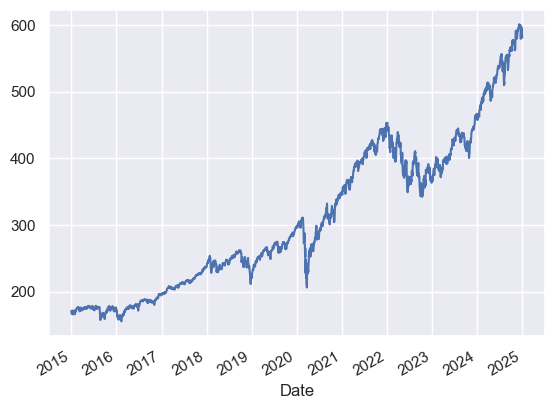

In [ ]:
spy['close'].plot()

<Axes: ylabel='Frequency'>

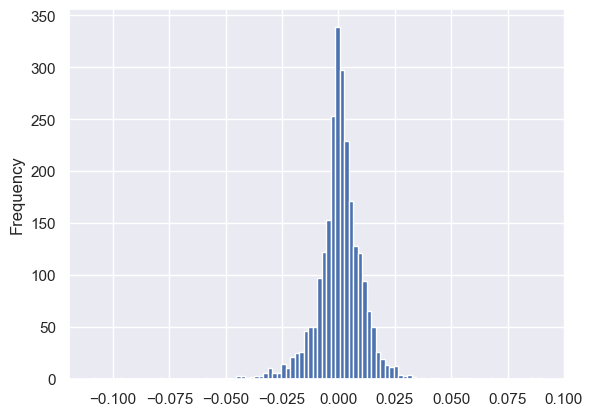

In [ ]:
spy.loc[:, 'returns'] = spy['close'].pct_change()

spy['returns'].plot(kind='hist', bins=100)

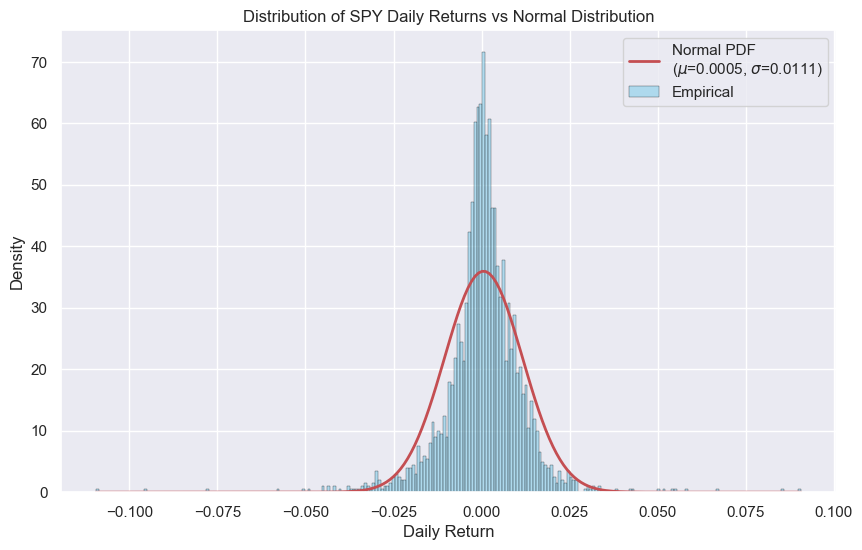

In [ ]:
# Drop NA values from returns
returns_spy = spy["returns"].dropna()

# Estimate mean and std of returns
mu_spy, sigma_spy = returns_spy.mean(), returns_spy.std()

# Create a range of values for the normal PDF
x = np.linspace(returns_spy.min(), returns_spy.max(), 200)
pdf_spy = norm.pdf(x, mu_spy, sigma_spy)

# Plot histogram of returns with seaborn
plt.figure(figsize=(10, 6))
sns.histplot(returns_spy, bins=250, stat="density", color="skyblue", edgecolor="black", alpha=0.6, label="Empirical")

# Plot the normal PDF
plt.plot(x, pdf_spy, 'r-', lw=2, label=f"Normal PDF\n($\\mu$={mu_spy:.4f}, $\\sigma$={sigma_spy:.4f})")

plt.title("Distribution of SPY Daily Returns vs Normal Distribution")
plt.xlabel("Daily Return")
plt.ylabel("Density")
plt.legend()
plt.show()


### Now let's compare it with NVDA

In [ ]:
nvd = yf.download("NVDA", start=START_DATE, end=END_DATE, auto_adjust=True)

new_columns = ['close', 'high', 'low', 'open', 'volume']

nvd.columns = new_columns

nvd.head()

[*********************100%***********************]  1 of 1 completed


,close,high,low,open,volume
Date,,,,,
2015-01-02,0.483038,0.486638,0.475360,0.483038,113680000
2015-01-05,0.474880,0.484478,0.472720,0.483038,197952000
2015-01-06,0.460482,0.476079,0.460002,0.475600,197764000
2015-01-07,0.459282,0.467921,0.457843,0.463842,321808000
2015-01-08,0.476559,0.479439,0.464321,0.464561,283780000


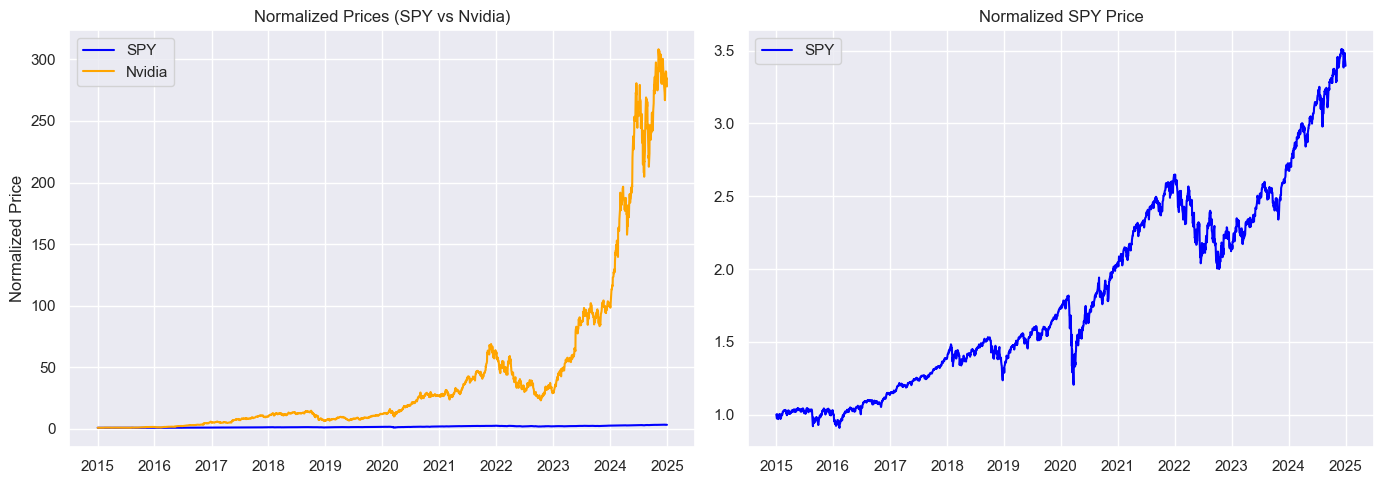

In [ ]:
import matplotlib.pyplot as plt

# Normalize prices (start at 1)
spy_norm = spy["close"] / spy["close"].iloc[0]
nvd_norm = nvd["close"] / nvd["close"].iloc[0]

# Create 1 row, 2 column figure
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

# Left plot: SPY vs Nvidia normalized
axes[0].plot(spy.index, spy_norm, label="SPY", color="blue")
axes[0].plot(nvd.index, nvd_norm, label="Nvidia", color="orange")
axes[0].set_title("Normalized Prices (SPY vs Nvidia)")
axes[0].set_ylabel("Normalized Price")
axes[0].legend()

# Right plot: SPY only normalized
axes[1].plot(spy.index, spy_norm, label="SPY", color="blue")
axes[1].set_title("Normalized SPY Price")
axes[1].legend()

plt.tight_layout()
plt.show()


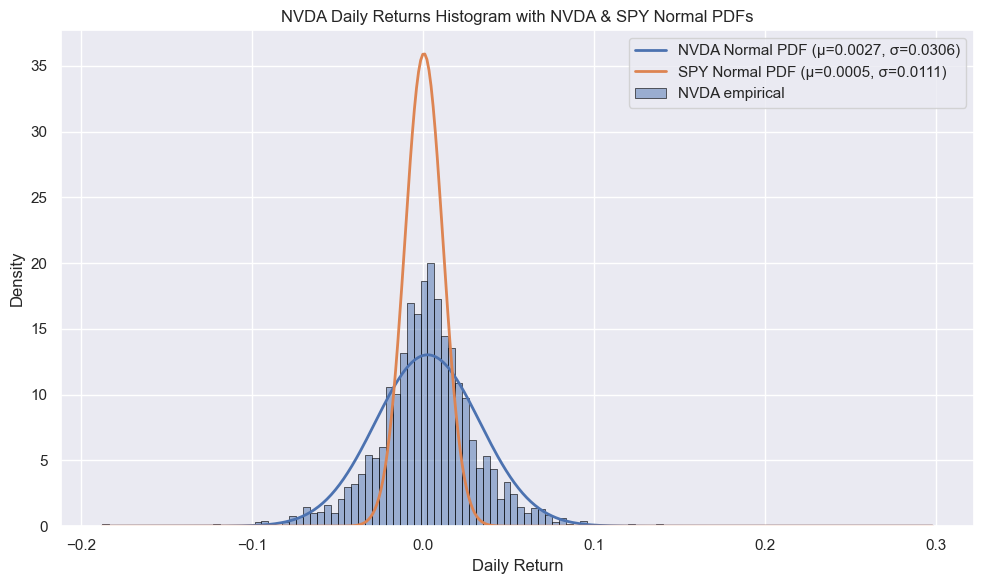

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

# If your dataframes have 'Close' instead of 'close', change the keys accordingly.
# Compute returns
nvd["returns"] = nvd["close"].pct_change()
spy["returns"] = spy["close"].pct_change()

# Drop NA
nvda_ret = nvd["returns"].dropna()
spy_ret = spy["returns"].dropna()

# Sample mean/std
mu_nvda, sigma_nvda = nvda_ret.mean(), nvda_ret.std()
mu_spy,  sigma_spy  = spy_ret.mean(),  spy_ret.std()

# x-range covering BOTH series for a fair visual comparison
x_min = min(nvda_ret.min(), spy_ret.min())
x_max = max(nvda_ret.max(), spy_ret.max())
x = np.linspace(x_min, x_max, 400)

# Normal PDFs implied by sample moments
pdf_nvda = norm.pdf(x, mu_nvda, sigma_nvda)
pdf_spy  = norm.pdf(x, mu_spy,  sigma_spy)

# Plot
sns.set_theme()
plt.figure(figsize=(10, 6))

# Histogram of NVDA returns as density
sns.histplot(nvda_ret, bins=120, stat="density", edgecolor="black", alpha=0.5, label="NVDA empirical")

# Overlay PDFs
plt.plot(x, pdf_nvda, linewidth=2, label=f"NVDA Normal PDF (μ={mu_nvda:.4f}, σ={sigma_nvda:.4f})")
plt.plot(x, pdf_spy,  linewidth=2, label=f"SPY Normal PDF (μ={mu_spy:.4f}, σ={sigma_spy:.4f})")

plt.title("NVDA Daily Returns Histogram with NVDA & SPY Normal PDFs")
plt.xlabel("Daily Return")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()


## Now let's understand the "fat tails"

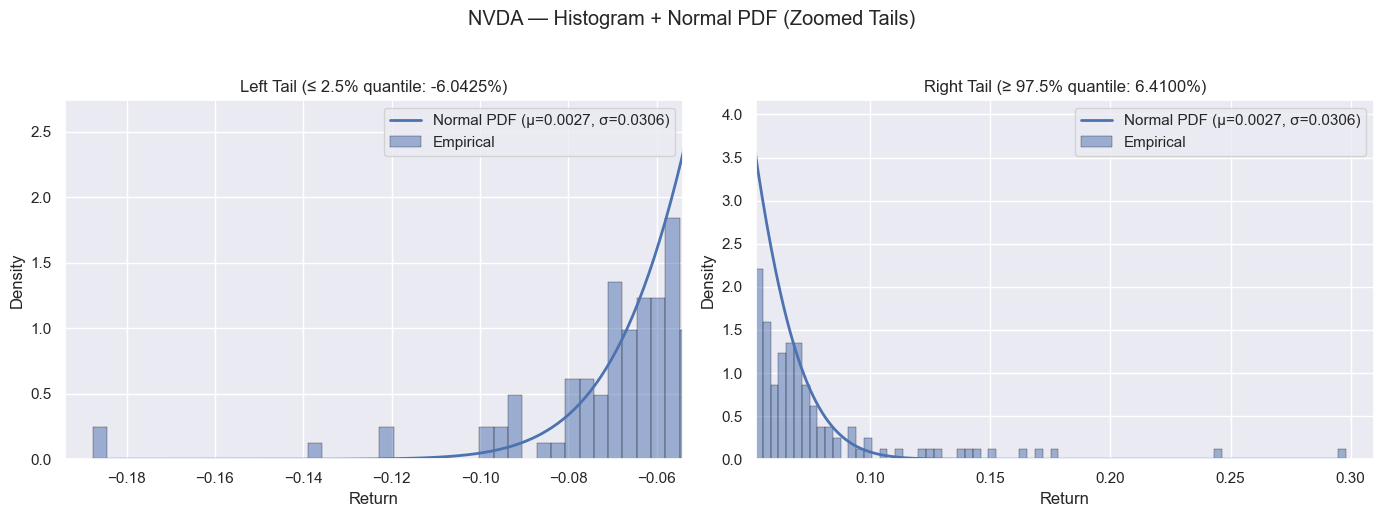

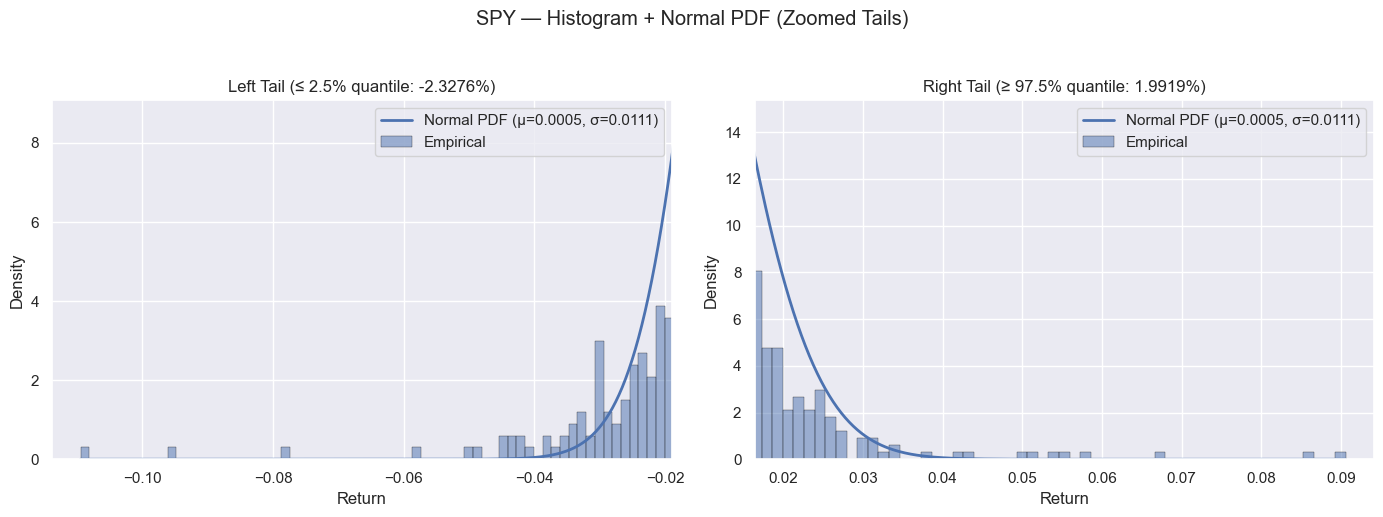

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

sns.set_theme()

def _close_col(df):
    return "close" if "close" in df.columns else "Close"

def tail_zoom_hist_with_normal(df, label, tail_q=0.025, bins=120):
    # returns + moments
    r = df[_close_col(df)].pct_change().dropna()
    mu, sigma = r.mean(), r.std()

    # full-range x for the normal curve
    x = np.linspace(r.min(), r.max(), 800)
    pdf = norm.pdf(x, mu, sigma)

    # quantile cutoffs
    q_lo, q_hi = r.quantile(tail_q), r.quantile(1 - tail_q)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)
    fig.suptitle(f"{label} — Histogram + Normal PDF (Zoomed Tails)", y=1.03)

    # --- Left tail zoom ---
    ax = axes[0]
    sns.histplot(r, bins=bins, stat="density", edgecolor="black", alpha=0.5, ax=ax, label="Empirical")
    ax.plot(x, pdf, linewidth=2, label=f"Normal PDF (μ={mu:.4f}, σ={sigma:.4f})")

    # zoom in on left tail
    margin = (q_lo - r.min()) * 0.05
    ax.set_xlim(r.min() - margin, q_lo + margin)

    # adjust ylim to max density in this region
    mask_left = (x >= r.min() - margin) & (x <= q_lo + margin)
    ymax_left = max(pdf[mask_left].max(), 1e-6) * 1.2
    ax.set_ylim(0, ymax_left)

    ax.set_title(f"Left Tail (≤ {tail_q:.1%} quantile: {q_lo:.4%})")
    ax.set_xlabel("Return")
    ax.set_ylabel("Density")
    ax.legend()

    # --- Right tail zoom ---
    ax = axes[1]
    sns.histplot(r, bins=bins, stat="density", edgecolor="black", alpha=0.5, ax=ax, label="Empirical")
    ax.plot(x, pdf, linewidth=2, label=f"Normal PDF (μ={mu:.4f}, σ={sigma:.4f})")

    # zoom in on right tail
    margin = (r.max() - q_hi) * 0.05
    ax.set_xlim(q_hi - margin, r.max() + margin)

    # adjust ylim to max density in this region
    mask_right = (x >= q_hi - margin) & (x <= r.max() + margin)
    ymax_right = max(pdf[mask_right].max(), 1e-6) * 1.2
    ax.set_ylim(0, ymax_right)

    ax.set_title(f"Right Tail (≥ {1 - tail_q:.1%} quantile: {q_hi:.4%})")
    ax.set_xlabel("Return")
    ax.set_ylabel("Density")
    ax.legend()

    plt.tight_layout()
    plt.show()

# Example usage:
tail_zoom_hist_with_normal(nvd, "NVDA", tail_q=0.025, bins=150)
tail_zoom_hist_with_normal(spy, "SPY",  tail_q=0.025, bins=150)


## Now let's try to trade stupidly

In [ ]:
spy.head()

,close,high,low,open,volume,returns
Date,,,,,,
2015-01-02,171.093674,172.301326,170.052603,171.884897,121465900,NaN
2015-01-05,168.003876,170.210941,167.695723,170.044372,169632600,-0.018059
2015-01-06,166.421402,168.836681,165.621854,168.311977,209151400,-0.009419
2015-01-07,168.495193,168.836668,167.304215,167.753952,125346700,0.012461
2015-01-08,171.485123,171.701673,169.894377,169.911025,147217800,0.017745


In [ ]:
import pandas as pd

# Add a boolean column for Monday
spy["is_monday"] = (spy.index.weekday == 0).astype(int)

spy.head()


,close,high,low,open,volume,returns,is_monday
Date,,,,,,,
2015-01-02,171.093674,172.301326,170.052603,171.884897,121465900,NaN,0
2015-01-05,168.003876,170.210941,167.695723,170.044372,169632600,-0.018059,1
2015-01-06,166.421402,168.836681,165.621854,168.311977,209151400,-0.009419,0
2015-01-07,168.495193,168.836668,167.304215,167.753952,125346700,0.012461,0
2015-01-08,171.485123,171.701673,169.894377,169.911025,147217800,0.017745,0


<Axes: xlabel='Date'>

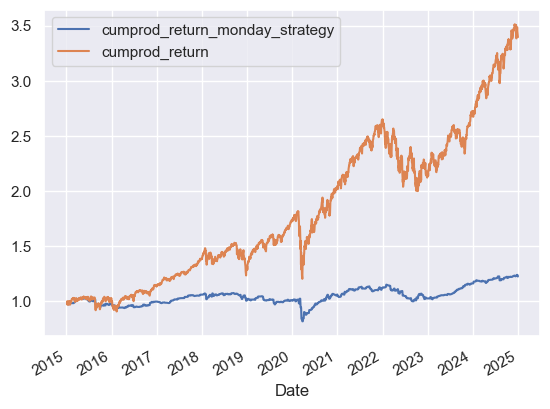

In [ ]:
spy.loc[:, 'return_monday_strategy'] = spy['is_monday'] * spy['returns']

spy.loc[:, 'cumprod_return_monday_strategy'] = (1 + spy['return_monday_strategy']).cumprod()
spy.loc[:, 'cumprod_return'] = (1 + spy['returns']).cumprod()
spy.head()

spy['cumprod_return_monday_strategy'].plot(legend='monday strat')
spy['cumprod_return'].plot(legend='benchmark spy')



In [ ]:
mu_monday = spy['return_monday_strategy'].mean()
std_monday = spy['return_monday_strategy'].std()

sr_monday = np.sqrt(252) * mu_monday / std_monday

print(f'The sr of monday is {sr_monday}')

The sr of monday is 0.2905168710446214


In [ ]:
spy['signal_trend_following'] = np.where(spy['returns'] > 0, 1, -1)
spy['signal_trend_following'] = spy['signal_trend_following'].shift(1)

spy.head()

,close,high,low,open,volume,returns,is_monday,return_monday_strategy,cumprod_return_monday_strategy,cumprod_return,signal_trend_following
Date,,,,,,,,,,,
2015-01-02,171.093674,172.301326,170.052603,171.884897,121465900,NaN,0,NaN,NaN,NaN,NaN
2015-01-05,168.003876,170.210941,167.695723,170.044372,169632600,-0.018059,1,-0.018059,0.981941,0.981941,-1.0
2015-01-06,166.421402,168.836681,165.621854,168.311977,209151400,-0.009419,0,-0.000000,0.981941,0.972692,-1.0
2015-01-07,168.495193,168.836668,167.304215,167.753952,125346700,0.012461,0,0.000000,0.981941,0.984813,-1.0
2015-01-08,171.485123,171.701673,169.894377,169.911025,147217800,0.017745,0,0.000000,0.981941,1.002288,1.0


<Axes: xlabel='Date'>

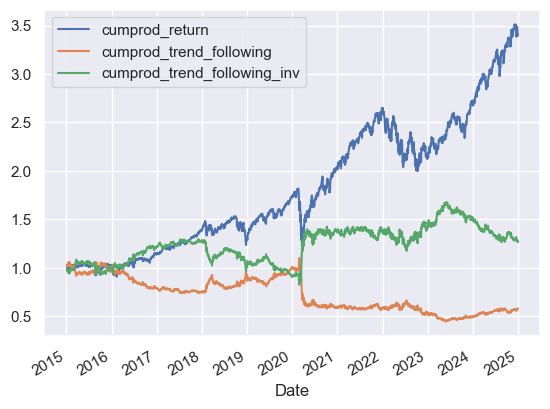

In [ ]:
spy.loc[:, 'returns_trend_following'] = spy['returns'] * spy['signal_trend_following']
spy.loc[:, 'returns_trend_following_inv'] = spy['returns'] * spy['signal_trend_following'] * -1

spy.loc[:, 'cumprod_trend_following'] = (1 + spy['returns_trend_following']).cumprod()
spy.loc[:, 'cumprod_trend_following_inv'] = (1 + spy['returns_trend_following_inv']).cumprod()

spy['cumprod_return'].plot(legend=True)
spy['cumprod_trend_following'].plot(legend=True)
spy['cumprod_trend_following_inv'].plot(legend=True)

In [ ]:
mu_spy = spy['returns'].mean()
std_spy = spy['returns'].std()
sr_spy = mu_spy/std_spy


mu_tf = spy['returns_trend_following'].mean()
std_tf = spy['returns_trend_following'].std()
sr_tf = mu_tf/std_tf

mu_tfi = spy['returns_trend_following_inv'].mean()
std_tfi = spy['returns_trend_following_inv'].std()
sr_tfi = mu_tfi/std_tfi

print(f'The sr of spy is {np.sqrt(252)*sr_spy}')
print(f'The sr of tf is {np.sqrt(252)*sr_tf}')
print(f'The sr of tfi is {np.sqrt(252)*sr_tfi}')

The sr of spy is 0.7838640264107499
The sr of tf is -0.22182072321184496
The sr of tfi is 0.22182072321184496


## Let's throw in the BTC as we all love cryptos

[*********************100%***********************]  1 of 1 completed

The sr of btc is 0.9732128578419866


<Axes: xlabel='Date'>

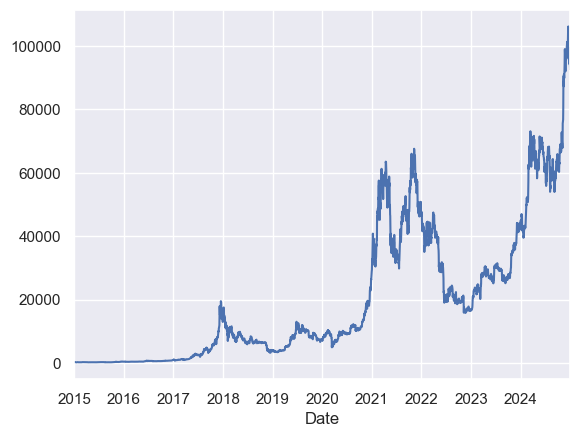

In [ ]:
btc = yf.download("BTC-USD", start=START_DATE, end=END_DATE, auto_adjust=True)

btc.columns = new_columns
btc.loc[:, 'returns'] = btc['close'].pct_change()

mu_btc = btc['returns'].mean()
std_btc = btc['returns'].std()
sr_btc = np.sqrt(252)*mu_btc / std_btc

print(f'The sr of btc is {sr_btc}')

btc['close'].plot()

## CHARAF TO DO

In [ ]:
df_1 = yf.download("MCD", start="2015-01-01", end="2025-01-01", auto_adjust=True)
df_1.columns = new_columns
df_1 = df_1[['close', 'volume']]
df_1.loc[:, 'ret'] = df_1['close'].pct_change()
df_1.loc[:, 'cumprod'] = (1 +df_1['ret']).cumprod()

df_2 = yf.download('QSR', start="2015-01-01", end="2025-01-01", auto_adjust=True)
df_2.columns = new_columns
df_2 = df_2[['close', 'volume']]
df_2.loc[:, 'ret'] = df_2['close'].pct_change()
df_2.loc[:, 'cumprod'] = (1 +df_2['ret']).cumprod()

df = pd.merge(df_1, df_2, left_index=True, right_index=True, suffixes=['_MCD', '_QSR'])

df.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,close_MCD,volume_MCD,ret_MCD,cumprod_MCD,close_QSR,volume_QSR,ret_QSR,cumprod_QSR
Date,,,,,,,,
2015-01-02,71.094566,6019700,NaN,NaN,28.264400,749800,NaN,NaN
2015-01-05,70.309326,6211900,-0.011045,0.988955,27.880857,1169600,-0.013570,0.986430
2015-01-06,70.438950,6484100,0.001844,0.990778,27.932491,1532500,0.001852,0.988257
2015-01-07,71.666290,6400300,0.017424,1.008042,29.009375,2298400,0.038553,1.026357
2015-01-08,71.933105,5476700,0.003723,1.011795,29.761711,1730100,0.025934,1.052975


In [ ]:
# window = 150

# cov_prices = df['close_MCD'].rolling(window=window, min_periods=window).cov(df['close_QSR'])
# var_prices = df['close_QSR'].rolling(window=window, min_periods=window).var()

# df['rolling_beta_150_prices'] = cov_prices / var_prices

# df.dropna().head()

<Axes: xlabel='Date'>

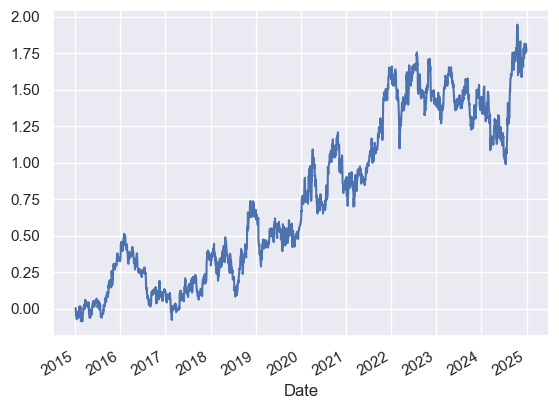

In [ ]:
(df['cumprod_MCD'] - df['cumprod_QSR']).plot()

## Now it's your turn to dive in !

Now that we have seen some basics, you will try to find out some trading strategies, build some signals. 

You are free to use chatgpt and the previous lines of code to download, explore the data, try to find some patterns.

If you wish to try out and build some simple indicators, down below are some small exercises

### Exercise 1 : computation of trading indicators

In [ ]:
import yfinance as yf
import pandas as pd
import seaborn as sns 
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt


sns.set_theme()

START_DATE = "2021-01-01"
END_DATE = "2025-01-01"


btc = yf.download("BTC-USD", start=START_DATE, end=END_DATE, auto_adjust=True)
btc.columns = new_columns

eth = yf.download("ETH-USD", start=START_DATE, end=END_DATE, auto_adjust=True)
eth.columns = new_columns

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BTC-USD']: Timeout('Failed to perform, curl: (28) Resolving timed out after 10001 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
Failed to get ticker 'ETH-USD' reason: Failed to perform, curl: (6) Could not resolve host: query2.finance.yahoo.com. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ETH-USD']: DNSError('Failed to perform, curl: (6) Could not resolve host: query2.finance.yahoo.com. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


In [25]:
# Here please compute he moving average of the 

eth

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,ETH-USD,ETH-USD,ETH-USD,ETH-USD,ETH-USD,ETH-USD
Date,,,,,,
